# Settling Time After a Slew 
# (RMS exceed method)

This notebook will return a settling time. 

Method: We will measure the RMS of the displacement values with respect to a long term value of positions and rotations measured by the IMS at M1M3 which shouldn't exceed the IMS repeatability error in 1 sec time range after the slew stop. We will determine the "settle" to be the point after the last point that exceeds RMS limit.

[LVV-T11258]: https://jira.lsstcorp.org/browse/LVV-11258

### Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from scipy import stats

from lsst.summit.utils.tmaUtils import TMAEventMaker, TMAState
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
from lsst.summit.utils.blockUtils import BlockParser

import warnings

warnings.filterwarnings("ignore")

In [3]:
# create a client to retrieve datasets in the EFD database
client = makeEfdClient()

### Define relevant settings

#### Requirements

In [4]:
req_delta_t = 1.0  ## seconds after slew
req_rms_position = (
    2e-3  ## mm, tolerance from repeatability requirement for IMS positional
)
req_rms_rotation = (
    3e-5  ## degrees, tolerance from repeatability requirement for IMS rotational
)

#### Observation day

In [5]:
## Insert here the dayObs of interest
dayObs = 20231129  # 20231122

#### Reference time (padding after slew)

In [6]:
# define time padding after end of slew
postPadding = 15  # in seconds, integration time will be 30 s

#### Define column names

In [7]:
## Define column names
all_columns = [
    "xPosition",
    "yPosition",
    "zPosition",
    "xRotation",
    "yRotation",
    "zRotation",
]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]

### Define functions

#### measure settling time



In [21]:
def computeSettleTime(
    df_ims,  # input data frame
    referenceTime="2023-06-01T06:00:0Z",  # time for slew stop
    lo_delta_t=5,  # in seconds
    hi_delta_t=30,  # in seconds
    imsColumn="xPosition",  # IMS column
    rmsReq=2e-3,  # requirement in appropriate units
    req_delta_t=3,
):  # time for settling, in seconds
    # repeatability requirements are 2 microns in position and 30 microdegs in rotation
    if "Position" in imsColumn:
        units = "mm"
        print("rmsReq=%e" % rmsReq)
        ylimMax = rmsReq + 0.001
    elif "Rotation" in imsColumn:
        units = "deg"
        print("rmsReq=%e" % rmsReq)
        ylimMax = rmsReq + 0.00001
    else:
        print("Unidentified column")
        return -1

    # T0 and T1 defines the window for requirement to be met
    T0 = pd.to_datetime(referenceTime)
    T1 = T0 + pd.to_timedelta(req_delta_t, unit="s")

    # delta_window is the time window for plot and reference for mean, before and after T0
    delta_window = [
        pd.Timedelta(lo_delta_t, "seconds"),
        pd.Timedelta(hi_delta_t, "seconds"),
    ]
    # zoom around the T0 of interest
    TZoom = [T0 - delta_window[0], T0 + delta_window[1]]

    targetVariablePlot = df_ims[imsColumn][TZoom[0] : TZoom[1]]  # complete plot range
    targetVariableWindow = df_ims[imsColumn][
        T0:T1
    ]  # from slew stop to end of req. window
    idxT0 = df_ims.index[
        df_ims.index.get_indexer([pd.to_datetime(T0)], method="nearest")
    ]
    idxT1 = df_ims.index[
        df_ims.index.get_indexer([pd.to_datetime(T1)], method="nearest")
    ]
    idxTend = df_ims.index[
        df_ims.index.get_indexer(
            [pd.to_datetime(T0 + delta_window[1])], method="nearest"
        )
    ]
    targetVariableReference = [
        df_ims[imsColumn][idxT0],
        float(df_ims[imsColumn][idxTend]),
    ]
    # at slew stop and end of plot
    # print('At T1',df_ims[imsColumn][idxT1].get_indexer())

    if len(targetVariablePlot.index) == 0:
        print("Data frame is empty")
        return -1

    # rms of difference wrt to end of plot, of values within requirement in window
    # it is important that the end of the plot (targetVariableReference) does not hit another
    # slew or movement, nor at any point in the middle of the window
    rms = np.std(targetVariableWindow - targetVariableReference[1])

    title = imsColumn
    label = imsColumn + "(" + units + ") wrt value at slew stop"

    fig = plt.figure()
    plt.plot(
        targetVariablePlot - targetVariableReference[0][0],
        color="red",
        lw="0.5",
        label=label,
    )
    plt.axvline(T0, lw="1.25", c="k", ls="dashed", label="Slew stop")
    plt.axhline(-rmsReq, lw="0.75", c="k", ls="dashed", label="IMS repeatability req.")
    plt.axhline(rmsReq, lw="0.75", c="k", ls="dashed")
    plt.xlabel("Time [UTC]")
    plt.ylabel(label)

    fig.autofmt_xdate()
    fig.tight_layout()

    ## recomputing RMS for the whole range since T0
    rolling = 20
    time_array = df_ims.index
    slew_stop = Time(referenceTime).unix
    iT0 = np.argmin(np.abs((Time(time_array).unix) - slew_stop))
    iT1 = np.argmin(np.abs((Time(time_array).unix) - (Time(time_array).unix[iT0] + 1)))
    targetVariable = df_ims[imsColumn][iT0:-1]
    rms = (targetVariable - targetVariableReference[1]).rolling(rolling).std()
    plt.plot(rms, label="RMS wrt value at the end of plot,\n from slew stop")
    plt.axvspan(T0, T1, alpha=0.5, color="green", label="1s tolerance window")
    # print(rms)
    # rms = rms.dropna()
    k = [index for index, x in enumerate(rms) if np.abs(x) >= rmsReq]
    if all(x < rmsReq for x in rms[iT1 - iT0 : -1]):
        if k == []:
            settleTime = 0
            k = [0]
            print("Settling time = 0 sec: Already settled at slew stop")
        else:
            settleTime = time_array[iT0 + k[-1]] - time_array[iT1]
            settleTime = settleTime.seconds
            print("settling_time=%.3f sec" % (settleTime))
        print("Test PASSED")
    else:
        settleTime = time_array[iT0 + k[-1]] - time_array[iT1]
        settleTime = settleTime.total_seconds() * 1000
        print("settling_time=%.3f sec" % (settleTime / 1000))
        print("Test FAILED")

    settled_time = time_array[iT0 + k[-1]].strftime("%H:%M:%S.%f")
    plt.axvline(time_array[iT1], lw="1", c="r", ls="--", label="settling time limit")
    plt.axvline(time_array[iT0 + k[-1]], lw="1.25", c="b", ls="-", label="Settled")

    plt.title("settling_time=%.3f sec" % (settleTime / 1000))
    plt.legend(loc="upper right", fontsize="8")

    fig = plt.figure()

#### compare IMS vs mount data

This is an auxiliary function to plot information from the IMS with respect to the elevation and azimuth measurements from the mount.

In [9]:
def compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    referenceTime="2023-06-01 06:53:37.326",
    lo_delta_t=5,  # in seconds
    hi_delta_t=60,  # in seconds
):
    fig, axs = plt.subplots(5, 1, dpi=125, figsize=(6, 8))
    t_start_plot = pd.to_datetime(referenceTime) - pd.to_timedelta(
        lo_delta_t, unit="s"
    )  ##correcting by hand for TAI, is this correct?
    t_end_plot = pd.to_datetime(referenceTime) + pd.to_timedelta(hi_delta_t, unit="s")

    ax = axs[0]
    actpos_ele = df_mtmount_ele["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_ele, color="red", lw="0.5")
    ax.axvline(pd.to_datetime(referenceTime), lw="0.5", c="k")
    ax.set_ylabel("Elevation \nPosition\n[deg]")

    ax = axs[1]
    actpos_azi = df_mtmount_azi["actualPosition"][t_start_plot:t_end_plot]
    ax.plot(actpos_azi, color="red", lw="0.5")
    ax.axvline(pd.to_datetime(referenceTime), lw="0.5", c="k", label="Slew stop")
    ax.set_ylabel("Azimuth \nPosition\n[deg]")

    t_start_plot = pd.to_datetime(referenceTime) - pd.to_timedelta(lo_delta_t, unit="s")
    t_end_plot = pd.to_datetime(referenceTime) + pd.to_timedelta(hi_delta_t, unit="s")

    plotstring = ["xPosition", "yPosition", "zPosition"]
    plotrange = np.arange(len(plotstring))
    for i in plotrange:
        ax = axs[i + 2]
        pos = df_ims[plotstring[i]][t_start_plot:t_end_plot]
        ax.plot(pos, color="red", lw="0.5")
        ax.axvline(pd.to_datetime(referenceTime), lw="0.5", c="k")
        ax.set_ylabel(plotstring[i] + " \n[mm]")
    ax.set_xlabel("UTC")
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=1)
    fig.suptitle(referenceTime)
    fig.legend()
    fig.tight_layout()
    ### TBD: use a delta time wrt slew stop in x-label

### Load data

#### Get slew stops

In [10]:
# Select data from a given date
eventMaker = TMAEventMaker()
events = eventMaker.getEvents(dayObs)

# Get lists of slew and track events
slews = [e for e in events if e.type == TMAState.SLEWING]
tracks = [e for e in events if e.type == TMAState.TRACKING]
print(f"Found {len(slews)} slews and {len(tracks)} tracks")

Found 492 slews and 378 tracks


In [11]:
# Get events related to soak tests (block 137 currently)
block137Events = []
for event in events:
    blockInfos = event.blockInfos
    if blockInfos is None:
        continue  # no block info attached to event at all

    # check if any of the attached blockInfos are for block 137
    blockNums = {b.blockNumber for b in blockInfos}
    if 137 in blockNums:
        block137Events.append(event)

print(f"Of the {len(events)} events, {len(block137Events)} relate to block 137.")

Of the 870 events, 750 relate to block 137.


In [12]:
# Print out sequential number of events that have certain characteristics
s = 0
for i in range(len(block137Events)):
    if (
        block137Events[i].endReason == TMAState.TRACKING
        and block137Events[i].type == TMAState.SLEWING
    ):
        s = s + 1
        print(block137Events[i].seqNum, end=", ")

11, 13, 15, 17, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 118, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336, 338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 363, 370, 372, 374, 377, 385, 395, 397, 399, 401, 403, 405, 407, 409, 411, 413, 415, 417, 419, 421, 423, 425, 427, 429, 431, 433, 435, 437, 439, 441, 443, 446, 448, 450, 452, 454, 456, 458, 460, 462, 464, 466, 468, 470, 472, 474, 476, 478, 480, 482, 484, 486, 488, 490, 492, 494, 496, 498, 500, 502, 504, 506, 508, 510, 512, 514, 516, 518, 520, 522, 52

In [13]:
targetSeqNum = 290

In [14]:
# find the appropriate slews index that has the sequential number selected above
for s, sl in enumerate(slews):
    if sl.seqNum == targetSeqNum:
        i_slew = s
        break
print(f"Event with seqNum {targetSeqNum} corresponds to slew number {i_slew}")

Event with seqNum 290 corresponds to slew number 185


In [15]:
t0 = Time(slews[i_slew].begin, format="isot", scale="utc")
t0 = pd.to_datetime(t0.value, utc=True)  # astropy Time to Timestamp conversion
t1 = Time(slews[i_slew].end, format="isot", scale="utc")
t1 = pd.to_datetime(t1.value, utc=True)  # astropy Time to Timestamp conversion
t2 = Time(slews[i_slew + 1].begin.isot, format="isot", scale="utc")
t2 = pd.to_datetime(t2.value, utc=True)  # astropy Time to Timestamp conversion
postPadding = t2 - t1
postPadding = postPadding.seconds

print("Slew stop at:", t1)
# Get IMS data

df_ims = getEfdData(
    client, "lsst.sal.MTM1M3.imsData", event=slews[i_slew], postPadding=postPadding
)
df_ims = df_ims[all_columns]
# Convert meter to milimeter
df_ims[pos_columns] = df_ims[pos_columns] * 1e3

Slew stop at: 2023-11-30 02:41:57.264000+00:00


In [16]:
# Get mount data
df_mtmount_ele = getEfdData(
    client, "lsst.sal.MTMount.elevation", event=slews[i_slew], postPadding=postPadding
)
df_mtmount_azi = getEfdData(
    client, "lsst.sal.MTMount.azimuth", event=slews[i_slew], postPadding=postPadding
)

### Look at data

This step is not necessary, but useful to get a visual impression of how the IMS data vary with TMA movements.

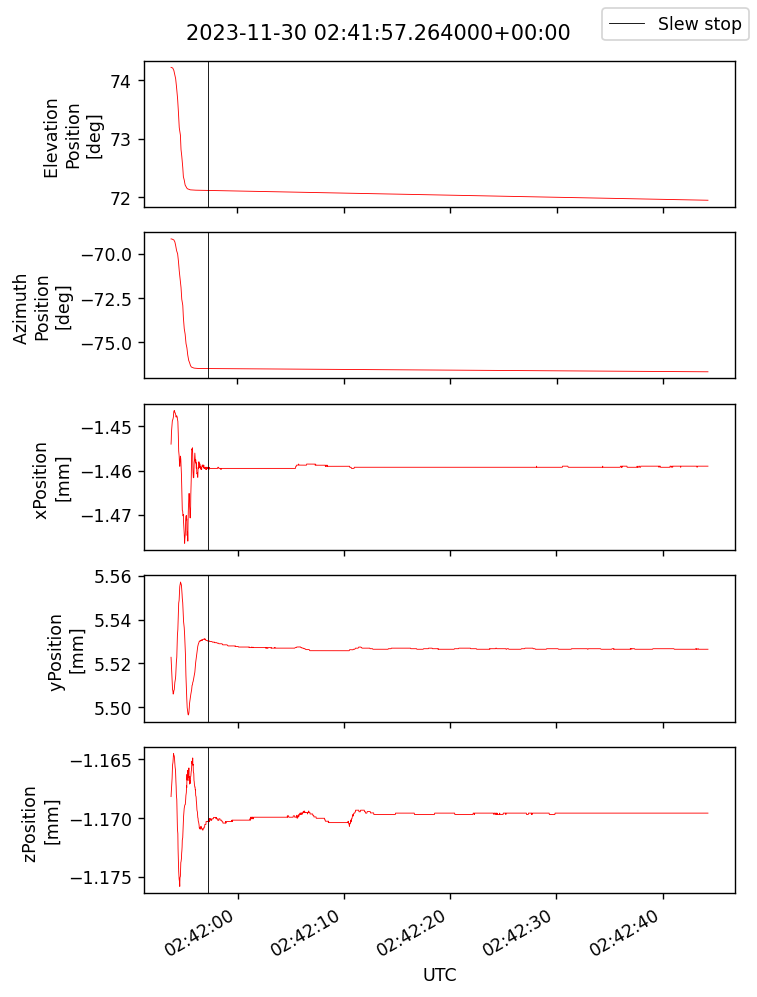

In [17]:
%matplotlib inline
compareIMSMount(
    df_ims,
    df_mtmount_ele,
    df_mtmount_azi,
    t1,
    10,
    pd.to_timedelta(postPadding, unit="s"),
)

### Run test

Currently the test involves executing the computeSettleTime function, an example is shown below. The test will return a PASS if the rms of the fluctuation of the variable around the value at the end of the set window (set at postPadding above) is always below the requirement, in the required time after the slew stop event. Two plots are shown, the first showing the value and RMS, until the end of the window, the second zooming in on the requirement time period.

rmsReq=3.000000e-05
Settling time = 0 sec: Already settled at slew stop
Test PASSED


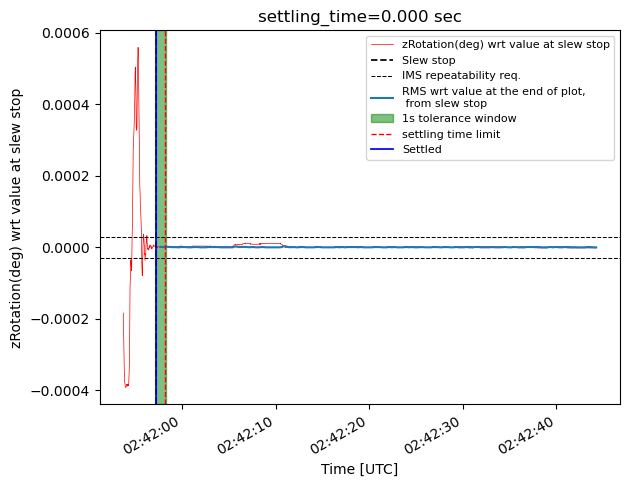

<Figure size 640x480 with 0 Axes>

In [24]:
# this is an example call for a single column of the IMS data frame
computeSettleTime(
    df_ims=df_ims,
    referenceTime=t1,
    lo_delta_t=5,
    hi_delta_t=postPadding,
    imsColumn="zRotation",
    rmsReq=req_rms_rotation,
    req_delta_t=req_delta_t,
)